In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as Fn
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from scipy.io import savemat
from time import time
from sklearn.metrics import roc_auc_score
import torch.optim as optim
import os

from PIL import Image
from utils import iou,iou1,resize,load_PCA,load_1PCA,get_nov_patches,set_nov_patches,plot_edge_overlay

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
path='./WeizmannHorse/'
#path='d:/datasets/birds/images_all/'

# Specify the columns you want to read
with open(path+'/train.txt', 'r') as f:
    train = f.read().splitlines()
with open(path+'/test.txt', 'r') as f:
    test = f.read().splitlines()

print(len(train),len(test))

159 168


torch.Size([159, 4, 384, 384]) torch.Size([168, 4, 384, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


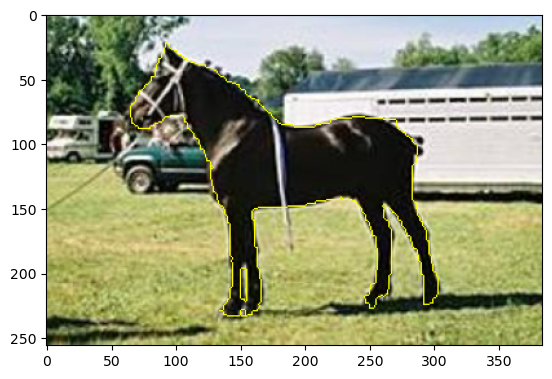

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


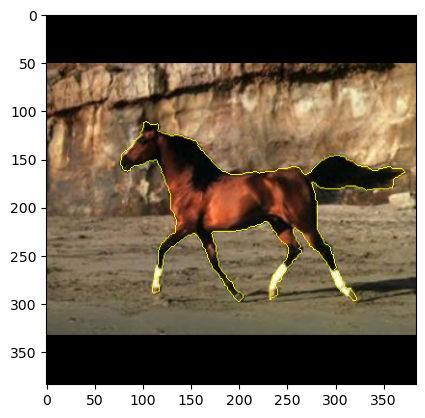

In [9]:
### Build a newdataset with 4 channels, first three for rgb and the last one for the mask:
import os
import torch
from torchvision import transforms
from torchvision.io.image import read_image,write_png

from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop,ToTensor, Normalize, Grayscale, RandomRotation
from torchvision.transforms.v2 import  RandomResize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC # resize the input image using bicubic interpolation, producing a smoother result compared to other interpolation methods like nearest-neighbor or bilinear.

from utils import make_square, plot_edge_overlay

def load_image_pairs(path,names,ext='jpg'):
    n=len(names)
    nx=384
    tr=Resize(nx, interpolation=InterpolationMode.BILINEAR)
    images=torch.zeros(n,4,nx,nx,device=device)
    crop=[]
    for i in range(n):
        name=path+'/rgb/'+names[i]+'.jpg'
        rgb_img = read_image(name).to(device)
        name=path+'/masks/'+names[i]+'.'+ ext
        mask_img = read_image(name).to(device)
        image=torch.cat((rgb_img,mask_img),dim=0)
        _,h,w=image.shape
        sz = max(h, w)
        #print(image.shape)
        nh,nw=(nx*h)//sz,(nx*w)//sz
        img=Resize([nh,nw], interpolation=InterpolationMode.BILINEAR)(image)
        #print(img.shape)
        image,cro=make_square(img/255)
        images[i,:,:,:]=image
        crop.append(cro)
    return images,torch.tensor(crop)

def _transf(nx2): 
    return Compose([
        Resize([nx2,nx2], interpolation=InterpolationMode.BILINEAR),
        Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
     ])

if 1: # horses
    img,crop=load_image_pairs(path,train,'jpg') 
    imt,cropt=load_image_pairs(path,test,'jpg')
else:# birds
    img,crop=load_image_pairs(path,train,'png') 
    imt,cropt=load_image_pairs(path,test,'png')
print(img.shape,imt.shape)

xt=_transf(384)(imt).to(device)
x0=_transf(384)(img).to(device)

t=transforms.ToTensor()
p=crop[0,:]
plot_edge_overlay(img[0,:3,p[0]:p[1],p[2]:p[3]].cpu(),img[0,3,p[0]:p[1],p[2]:p[3]].cpu().squeeze()>0.5,255)
plot_edge_overlay(imt[0][:3].cpu(),imt[0][3].cpu().squeeze()>0.5,255)

In [10]:
#m=torch.load('PCA_hb_32.pth')
m=torch.load('pca1_hb_256_8x8_100it_0.pth')
P=m['P'].to(device)  # list of PC-tensors, each representing one mask: contains PC npa patches ------>each element of size (256,128*128)
mx=m['mx'] # running average list

P=P[0:64,:].to(device)

nx=256
print(P.shape,mx.shape)

torch.Size([64, 1024]) torch.Size([1024])


In [11]:

def iouLoss(a,b,sigma=1):
    """
    Finds the IOU between img_tensors a and b
    """
    ioui=torch.sum(a*b)/torch.sum(torch.max(a,b))
    return ioui

### Function to calculate PCA-coefficients or PCA-loadings for an image:

def get_coeffs(im,mx,P):
    """
    Function to calculate PCA-coefficients or PCA-loadings for an image

    Args:
        im= image_array: Tensor.
        mx= list of running averages
        P= list of PC-vectors: list of npa elements, each element of size (256,128*128)

    Returns:
        c= PCA-coefficients , shape= (number of images,number of patches,256)
    """
    sz=int(im.shape[1]/len(mx)**0.5)
    pa=get_nov_patches(im.to(device),sz) #gives 16 patches for image size(128,128)
    npa=len(P) # 16 = number of elements in P = number of patches
    c=torch.zeros(im.shape[0],npa,P[0].shape[0]).to(device) # shape=(159,16,256)
    for i in range(npa):
        ci=(pa[i]-mx[i])@P[i].t() #centering the patches by subtracting the mean
                                  # find loadings by multiplying the centered pixels and PCs
        #print(ci.shape)
        c[:,i,:]=ci #loading or PC coeff for patch i
    return c

## Function to recreate the image tensor from the PCA coefficients:

def get_rec_pca(nx,c,mx,P):
    """
    Function to recreate the image of size nx, nx from PCA-coefficients

    Args:
        nx= size of the image wanted
        c= PCA-coefficients , shape= (number of images,number of patches,256)
    Returns:
        x= recreated img_array   (Tensor)
    """
    n=c.shape[0] # number of images
    npa=c.shape[1] # number of patches =16
    npx=int(npa**0.5) # from patches we are trying to get to pixels : opposite of get_nov_patches

    x=torch.zeros(n,npx*nx,npx*nx).to(device)
    i=0
    for ix in range(npx):
        for iy in range(npx): # controls the patch
            ci=c[:,i,:]
            xr=ci@P[i]+mx[i] #reconstructed image array = dot(coeff,PC)+mean
            x[:,ix*nx:ix*nx+nx,iy*nx:iy*nx+nx]=xr.reshape(-1,nx,nx) #reshape to get the image
            i+=1
    return x

def get_coeffs1(im,mx,P):
    """
    Function to calculate PCA-coefficients or PCA-loadings for an image

    Args:
        im= image_array: Tensor.
        mx= list of running averages
        P= list of PC-vectors: list of npa elements, each element of size (256,128*128)

    Returns:
        c= PCA-coefficients , shape= (number of images,number of patches,256)
    """
    sz=int(mx.shape[0]**0.5)
    pa=get_nov_patches(im.to(device),sz) #gives 16 patches for image size(128,128)
    npa=len(P) # 16 = number of elements in P = number of patches
    c=torch.zeros(im.shape[0],npa,P.shape[0]).to(device) # shape=(159,16,256)
    for i in range(npa):
        #print(pa[i].shape,mx.shape)
        ci=(pa[i]-mx)@P.t() #centering the patches by subtracting the mean
                                  # find loadings by multiplying the centered pixels and PCs
        #print(ci.shape)
        c[:,i,:]=ci #loading or PC coeff for patch i
    return c

def get_rec_1pca(nx,c,mx,P):
    """
    Function to recreate the image of size nx, nx from PCA-coefficients

    Args:
        nx= size of the image wanted
        c= PCA-coefficients , shape= (number of images,number of patches,256)
    Returns:
        x= recreated img_array   (Tensor)
    """
    n=c.shape[0] # number of images
    npa=c.shape[1] # number of patches =16
    npx=int(npa**0.5) # from patches we are trying to get to pixels : opposite of get_nov_patches

    x=torch.zeros(n,npx*nx,npx*nx).to(device)
    i=0
    for ix in range(npx):
        for iy in range(npx): # controls the patch
            ci=c[:,i,:]
            xr=ci@P+mx #reconstructed image array = dot(coeff,PC)+mean
            x[:,ix*nx:ix*nx+nx,iy*nx:iy*nx+nx]=xr.reshape(-1,nx,nx) #reshape to get the image
            i+=1
    return x

nx=256
x=_transfRC(5,nx)(xt)
x=x[:,3,:,:].to(device)
print(x.shape)
c=get_coeffs1(x,mx,P)
print('coeff shape',c.shape)
xr=get_rec_1pca(32,c,mx,P)
print(c.shape,xr.shape)
#ct=get_coeffs(xt,mx,P)
#xtr=get_rec_pca(32,ct,mx,P)
print(torch.mean(iou(x.reshape(-1,nx**2)>0.5,xr.reshape(-1,nx**2)>0.5)))
#print(torch.mean(iou(xt.reshape(-1,128**2)>0.5,xtr.reshape(-1,128**2).cpu()>0.5)))
i=11
plt.imshow(x[i,:].cpu().reshape(nx,nx)>0.5,cmap='gray')
plt.show()
plt.imshow(xr[i,:].cpu().reshape(nx,nx)>0.5,cmap='gray')

NameError: name '_transfRC' is not defined

In [12]:
# Import the pre-trained models

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights, list_models

def pcs(self, x):
    """
    Function to find the PCA-loadings using the ResNet
    """
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)                ### Base Block of ResNet18 : Input has 3 channels
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)             ##### the four layers
    x = self.layer4(x)

    x = self.fc(x)                 #### connecting fc layer
    return x

def make_resnet(nc):
    net=resnet50(weights=ResNet50_Weights.DEFAULT)
    net.fc=nn.Conv2d(2048,nc,1).to(device) # connecting layer to make the resnet worknet
    net=net.to(device)
    return net
    
net=make_resnet(64)
#net=models.get_model("vgg11", weights="DEFAULT")
#net.eval()
## (fc): Linear(in_features=512, out_features=1000, bias=True)---> need 256 output
#del net.layer4

In [13]:
o=pcs(net,x0[0:3,0:3,:,:])
o.shape

torch.Size([3, 64, 12, 12])

In [7]:
# Resnet with Attention
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights, list_models
from model import Attention, get_sinusoid_encoding_table

def pcs(self, x):
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    # if path_size is 32, need layer4
    x = self.layer4(x)

    B, C, H, W = x.size()

    x = x.reshape(B, C, -1)
    x = x.transpose(1, 2)

    x = x + self.att(x,x,x,need_weights=False)[0]
    #x = x + self.att(x)
 
    x = x.transpose(1, 2)
    x = x.reshape(B, C, H, W)

    x = self.fc(x)
    return x

dim_layer = 2048
num_pc = 64

net=resnet50(weights=ResNet50_Weights.DEFAULT)
net = net.to(device)
net.att = Attention(dim_layer, 4, True).to(device)
#net.att = nn.MultiheadAttention(dim_layer, 4, add_bias_kv=True).to(device)
net.fc = nn.Conv2d(dim_layer, num_pc, 1).to(device)
#del net.layer4

384
torch.Size([64, 1024]) torch.Size([1024])
ep 0, dx:25, iou:0.069
ep 10, dx:25, iou:0.749
ep 20, dx:25, iou:0.835
ep 30, dx:25, iou:0.869
ep 40, dx:25, iou:0.891
ep 50, dx:25, iou:0.905
ep 60, dx:25, iou:0.911
ep 70, dx:25, iou:0.915
ep 80, dx:25, iou:0.921
ep 90, dx:25, iou:0.925
train IOU 0.9318875220586669 test IOU 0.9032102103034655 time: 301.3270676136017


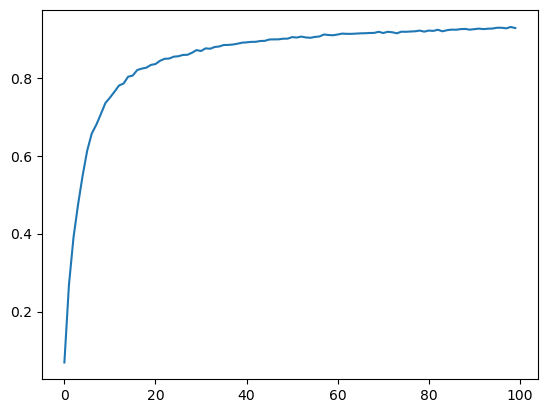

Resnet_horse32_384_100it_64p25r0.pth 0.9032102103034655
ep 100, dx:25, iou:0.930
ep 110, dx:25, iou:0.929
ep 120, dx:25, iou:0.935
ep 130, dx:25, iou:0.936
ep 140, dx:25, iou:0.938
ep 150, dx:25, iou:0.939
ep 160, dx:25, iou:0.942
ep 170, dx:25, iou:0.943
ep 180, dx:25, iou:0.944
ep 190, dx:25, iou:0.946
train IOU 0.9491287458617732 test IOU 0.9153182265304384 time: 609.2024629116058


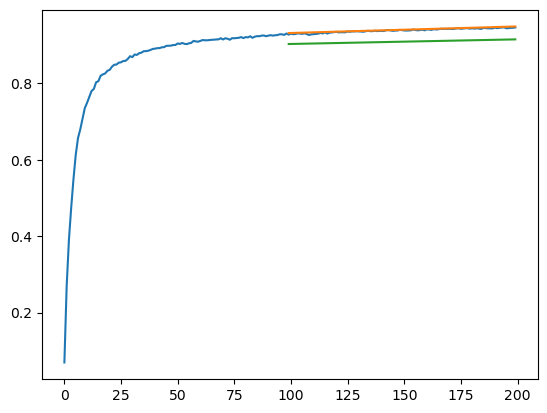

Resnet_horse32_384_100it_64p25r0.pth 0.9153182265304384
ep 200, dx:25, iou:0.946
ep 210, dx:25, iou:0.948


KeyboardInterrupt: 

In [15]:
from torchvision.transforms import ColorJitter
from time import time
from utils import iouLoss,_transfRRC4

def segment(loader,net,mx,P,px):
    out=[]
    for xi in loader:
        xi=xi[0][:,:3,:,:]
        with torch.no_grad():
            pc=pcs(net,xi)
            if px==32:
                pc=pc.permute(0,2,3,1)
            else:
                pc=po(pc).permute(0,2,3,1)
                #print('\n pc shape=',pc.shape)
            xr=pc@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)
            #print(xr.shape)
            xr=set_nov_patches(xr,px)
            out.append(xr)
    out=torch.cat(out,dim=0)
    return out.squeeze()
    
def eval1(img,crop,net,mx,P,px):
    nx=img.shape[2]
    img=img.to(device)
    data=TensorDataset(img.to(device)) 
    loader=DataLoader(data,batch_size=32,shuffle=False)
    xr=segment(loader,net,mx,P,px)
    n=img.shape[0]
    ious=[]
    for i in range(n):
        p=crop[i,:]
        xri=xr[i,p[0]:p[1],p[2]:p[3]]
        yi=img[i,3,p[0]:p[1],p[2]:p[3]]
        #print(xri.shape,yi.shape)
        io=iou1(xri.reshape(-1)>0.5,yi.reshape(-1)>0.5)
        ious.append(io)
    return ious

#form the dataloader
nx=xt.shape[2]
print(nx)
img=img.to(device)
data=TensorDataset(img.to(device)) 
loader=DataLoader(data,batch_size=4,shuffle=True)
nc=64 # number of PC coeffs
po=nn.AvgPool2d(2)
px=32 # patch size
#for r in range(0,1):
for r in [100]:#[1,10,100,1000]:
    torch.cuda.empty_cache()

    #m=torch.load('pca1_256_1x1_%dit_0.pth'%r)
    m=torch.load('pca1_hb_256_8x8_%dit_0.pth'%r)
    #m=torch.load('pca_horse_256_4x4_%dit_0.pth'%r)
    P=m['P'].to(device)  # list of PC-tensors, each representing one mask: contains PC npa patches ------>each element of size (256,128*128)
    mx=m['mx'] # running average list
    P=P[0:nc,:].to(device)
    print(P.shape,mx.shape)

    net=make_resnet(nc)
    #m=torch.load('ResNet50_birdsdetC_256_64p6r0.pth')
    #net=m['net']
    net=net.to(device)
    #net.att = Attention(2048, 4, True).to(device)
    #net.att = nn.MultiheadAttention(2048, 4, add_bias_kv=True).to(device)

    optimizer = optim.Adam(net.parameters(), lr=0.00003, weight_decay=0.000)
    #optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.7, weight_decay=0.000)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.4)

    t0=time()
    ## Epoch training start:
    losses=[]
    iout=[]
    ios=[]
    eps=[]
    maxi=0
    for epoch in range(2000):
        net.train()
        dx=25#min(8,1+int(epoch/150))
        sumloss=0
        for xi in loader:
            
            xi=xi[0]

            transform_data=_transfRRC4(2*dx,dx,nx)(xi)

            x1= transform_data[:,3,:,:] #shape tensor after transformation
            x2= transform_data[:,0:3,:,:] #rgb tensor after transformation

            #thresholding: chose this threshold because the values are between [0,1] after transformation:
            #x1[x1>0.5]=1
            #x1[x1<0.5]=0

            #print('x1,x2 shape==',x1.shape,x2.shape)
            optimizer.zero_grad()
           ## Calculate the pc-coeeficients using ResNet:
            pc=pcs(net,x2)
            if px==32:
                pc=pc.permute(0,2,3,1) # 32x32
            else:
                pc=po(pc).permute(0,2,3,1) # 64x64
            #print('\n pc shape=',pc.shape,P.shape)

            xr=pc@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)
            #print(xr.shape)
            xr=set_nov_patches(xr,px)
            #print('\n x2 recreated shape',xr.shape)

            ### Calculate the IOUloss:
            xr1=torch.sigmoid((xr-0.5)*50) # sigmopid is used to make it close to binary and differentiable
            loss=-iouLoss(xr1,(x1>0.5).float())  # iou between xr and shape tensor
            #print('iouloss=',loss)
            loss.backward()             # compute the gradients
            optimizer.step()            # optimize the loss function

            sumloss+=loss.item()*xi.shape[0]
                #print(sumloss)

        sumloss=sumloss/img.shape[0]

        losses.append(-sumloss)
        scheduler.step()

        #print results every 10 epoch, plot every 100
        if epoch%10==0:
            print('ep %d, dx:%d, iou:%.3f'%(epoch,dx,-sumloss))
        if epoch%100==99:
            #net.eval()
            ious=eval1(x0, crop,net,mx,P,px)
            iouts=eval1(xt, cropt,net,mx,P,px)
            io=np.mean(ious)
            #ious=iou(xtr.view(-1,nx**2)>0.5,xt[:,3,:,:].view(-1,nx**2)>0.5)
            iot=np.mean(iouts)
            print('train IOU',io,'test IOU',iot,'time:',time()-t0)
            iout.append(iot)
            ios.append(io)
            eps.append(epoch)
            plt.plot(losses)
            plt.plot(eps,ios)
            plt.plot(eps,iout)
            plt.show()
            if iot>maxi:
                maxi=iot
                name='Resnet_horse32_384_%dit_%dp25r0.pth'%(r,nc)
                print(name,maxi)
                torch.save({'losses':losses,'epochs':eps,'iout':iout,'ious':ios,'net':net,'time':time()-t0},name) 

In [11]:
def segment(loader,net,mx,P,px):
    out=[]
    for xi in loader:
        xi=xi[0][:,:3,:,:]
        with torch.no_grad():
            pc=spcs(net,xi)
            if px==32:
                pc=pc.permute(0,2,3,1)
            else:
                pc=po(pc).permute(0,2,3,1)
                #print('\n pc shape=',pc.shape)
            xr=pc@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)
            #print(xr.shape)
            xr=set_nov_patches(xr,px)
            out.append(xr)
    out=torch.cat(out,dim=0)
    return out.squeeze()
    
def eval1(img,crop,net,mx,P,px):
    nx=img.shape[2]
    img=img.to(device)
    data=TensorDataset(img.to(device)) 
    loader=DataLoader(data,batch_size=32,shuffle=False)
    xr=segment(loader,net,mx,P,px)
    n=img.shape[0]
    ious=[]
    for i in range(n):
        p=crop[i,:]
        xri=xr[i,p[0]:p[1],p[2]:p[3]]
        yi=img[i,3,p[0]:p[1],p[2]:p[3]]
        #print(xri.shape,yi.shape)
        io=iou1(xri.reshape(-1)>0.5,yi.reshape(-1)>0.5)
        ious.append(io)
    return ious

ious=eval1(x0, crop,net,mx,P,px)
iouts=eval1(xt, cropt,net,mx,P,px)
io=np.mean(ious)
#ious=iou(xtr.view(-1,nx**2)>0.5,xt[:,3,:,:].view(-1,nx**2)>0.5)
iot=np.mean(iouts)
print('train IOU',io,'test IOU',iot,'time:',time()-t0)

train IOU 0.9146933621830411 test IOU 0.8694517449254081 time: 5836.021543264389


In [42]:
m=torch.load('ResNet50_birds_128_64p.pth')
net=m['net']
P=m['P']  
mx=m['mx'] 

In [43]:
xr=segment(x0[:,0:3,:,:],net,mx,P)
xtr=segment(xt[:,0:3,:,:],net,mx,P)
ious=iou(xr.view(-1,128**2)>0.5,x0[:,3,:,:].view(-1,128**2)>0.5)
io=torch.mean(ious).item()
ious=iou(xtr.view(-1,128**2)>0.5,xt[:,3,:,:].view(-1,128**2)>0.5)
iot=torch.mean(ious).item()
print('train IOU',io,'test IOU',iot)

train IOU 0.9523058533668518 test IOU 0.806782066822052
